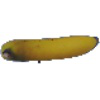

In [3]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import os
import PIL

import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

dataset = "https://www.kaggle.com/sshikamaru/fruit-recognition"

data_dir = pathlib.Path("../content/drive/MyDrive/Colab Notebooks/colab/Proyecto Said/train/train")

image_count = len(list(data_dir.glob('*/*.jpg')))

apricot = list(data_dir.glob('Banana/*'))
PIL.Image.open(str(apricot[0]))

In [ ]:
# creating batches
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 16854 files belonging to 33 classes.
Using 13484 files for training.
Found 16854 files belonging to 33 classes.
Using 3370 files for validation.
['Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry', 'Clementine', 'Corn', 'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon', 'Limes', 'Mango', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepper Green', 'Pepper Red', 'Pineapple', 'Plum', 'Pomegranate', 'Potato Red', 'Raspberry', 'Strawberry', 'Tomato', 'Watermelon']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.19806343 1.0


In [ ]:
num_classes = 33

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="reflect"),
    layers.RandomRotation(factor=(-0.2, 0.2)),
    #layers.RandomZoom(height_factor=(-0.4, -0.2),  width_factor=(-0.4, -0.2)),
    layers.RandomContrast(factor=[1.0, 3.0], seed=123 )
    
  ]
)


input_shape = (1, 180, 180, 3)
x = tf.random.normal(input_shape)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dense(num_classes)
])


In [ ]:
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.0005,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop",
)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


422/422 [==============================] - 905s 2s/step - loss: 2.2503 - accuracy: 0.3489 - val_loss: 1.6342 - val_accuracy: 0.4234
Epoch 2/10
422/422 [==============================] - 573s 1s/step - loss: 1.3116 - accuracy: 0.5743 - val_loss: 1.2177 - val_accuracy: 0.5831
Epoch 3/10
422/422 [==============================] - 575s 1s/step - loss: 1.0127 - accuracy: 0.6485 - val_loss: 0.9624 - val_accuracy: 0.6499
Epoch 4/10
422/422 [==============================] - 575s 1s/step - loss: 0.8713 - accuracy: 0.6936 - val_loss: 0.7769 - val_accuracy: 0.7297
Epoch 5/10
422/422 [==============================] - 570s 1s/step - loss: 0.7484 - accuracy: 0.7407 - val_loss: 0.7566 - val_accuracy: 0.7309
Epoch 6/10
422/422 [==============================] - 575s 1s/step - loss: 0.6748 - accuracy: 0.7608 - val_loss: 0.5375 - val_accuracy: 0.7941
Epoch 7/10
422/422 [==============================] - 575s 1s/step - loss: 0.5981 - accuracy: 0.7858 - val_loss: 0.8705 - val_accuracy: 0.6513
Epoch 8/10

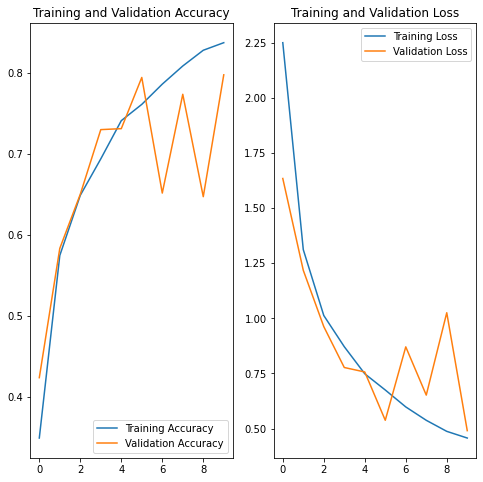

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 1s 534ms/step
This image most likely belongs to Pepper Red with a 96.13 percent confidence.


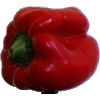

In [ ]:
sample_path = pathlib.Path("../content/drive/MyDrive/Colab Notebooks/colab/Proyecto Said/test/test/0083.jpg")

img = tf.keras.utils.load_img(
    sample_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 


predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Lo más probable es que esta imagen pertenezca  {}  {:.2f} con un porcentaje de confianza."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


PIL.Image.open(sample_path)

1/1 [==============================] - 0s 37ms/step
This image most likely belongs to Grape Blue with a 98.90 percent confidence.


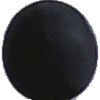

In [ ]:
sample_path = pathlib.Path("../content/drive/MyDrive/Colab Notebooks/colab/Proyecto Said/test/test/0001.jpg")

img = tf.keras.utils.load_img(
    sample_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 


predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Lo más probable es que esta imagen pertenezca  {}  {:.2f} con un porcentaje de confianza."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(sample_path)